In [79]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import scipy.stats
import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [80]:
#limits 
b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)
sigma_w_min, sigma_w_max = np.exp(-2), np.exp(2) #pick ln(sigma) uniform in [-2, 2]

limits = [b_min, b_max, A_min, A_max, t0_min, t0_max, alpha_min, alpha_max, sigma_w_min, sigma_w_max]

### functions

In [110]:
def burst_model(theta, t):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))

In [94]:
def gauss_model(theta, t):
    b, A, t0, sigma_w = theta
    return  b + A * np.exp( -(t - t0)**2 / (2*sigma_w**2))

In [95]:
def log_likelihood(theta, x, y, sigma, model):
    if model == 'burst_model':
        y_model = burst_model(theta, x)
    elif model == 'gauss_model':
        y_model = gauss_model(theta, x)
        
    return - 0.5 * np.sum((y - y_model)**2 / (2*sigma**2))

In [96]:
def prior(u, limits, model):
    b_min, b_max, A_min, A_max, t0_min, t0_max, alpha_min, alpha_max, sigma_w_min, sigma_w_max = limits
    
    x = np.array(u)
    x[0] = scipy.stats.uniform(loc = b_min, scale = b_max - b_min).ppf(u[0])
    x[1] = scipy.stats.uniform(loc = A_min, scale = A_max - A_min).ppf(u[1])
    x[2] = scipy.stats.uniform(loc = t0_min, scale = t0_max - t0_min).ppf(u[2])
    
    if model == 'burst_model':
        x[3] = scipy.stats.loguniform.ppf(u[3], alpha_min, alpha_max)
    elif model == 'gauss_model':
        x[3] = scipy.stats.loguniform.ppf(u[3], sigma_w_min, sigma_w_max)
    return x

### main

In [111]:
file = '../solutions/transient.npy'
data = np.load(file)
t = data[:,0]
flux = data[:,1]
sigma_flux = data[:,2]

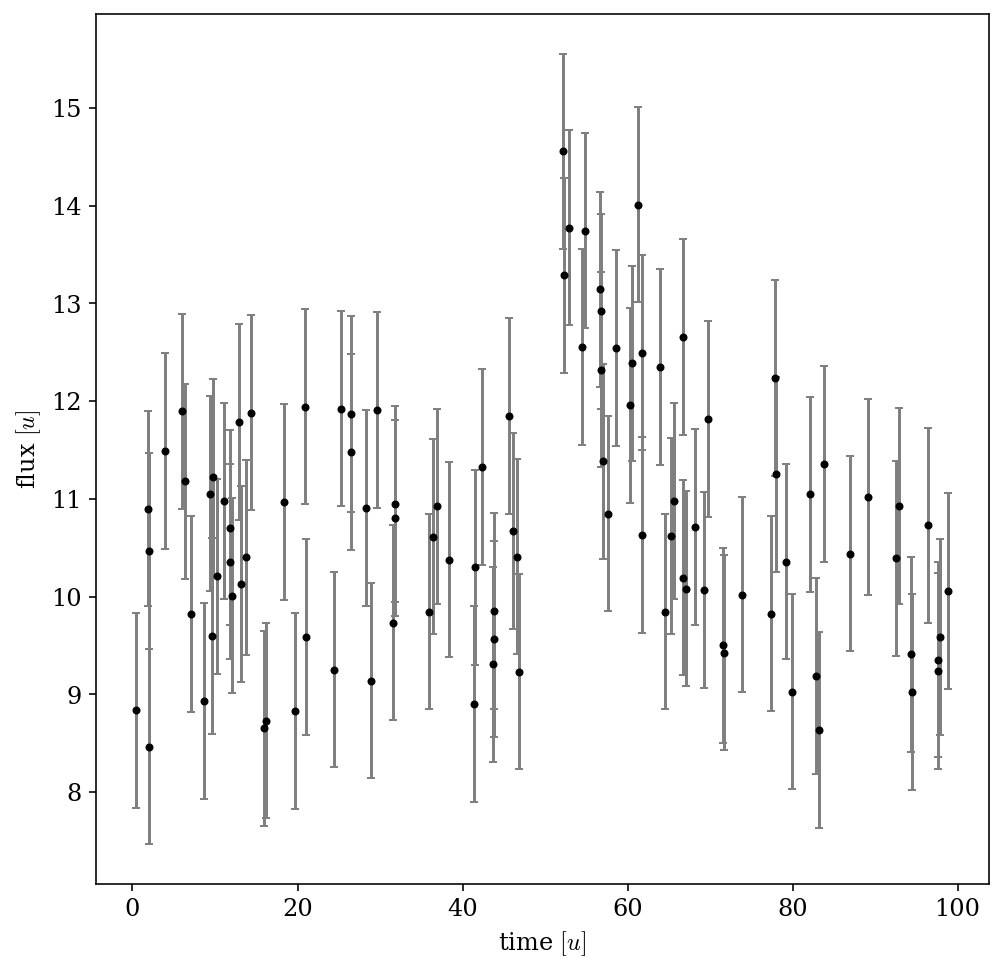

In [112]:
plt.errorbar(t, flux, yerr = sigma_flux, fmt ='.k', ecolor = 'gray', capsize = 2)
plt.xlabel(r'time $[u]$')
plt.ylabel(r'flux $[u]$')
plt.show()

### Burst model

In [113]:
#dynesty
ndim = 4
sampler = dynesty.NestedSampler(log_likelihood, prior, ndim, logl_args=[t, flux, sigma_flux, 'burst_model'], ptform_args=[limits, 'burst_model'], nlive = 100)
sampler.run_nested()
results = sampler.results

/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_10825/3611236607.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_10825/3611236607.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
316it [00:14,  6.14it/s, bound: 0 | nc: 54 | ncall: 3161 | eff(%):  9.997 | loglstar:   -inf < -96.024 <    inf | logz: -103.026 +/-  0.362 | dlogz: 56.799 >  0.109]      /var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_10825/3611236607.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_10825/3611236607.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
378it [00:15, 54.75it/s, bound: 1 | nc: 6 | ncall: 

829it [00:26, 28.79it/s, bound: 13 | nc: 9 | ncall: 5031 | eff(%): 16.478 | loglstar:   -inf < -42.434 <    inf | logz: -49.318 +/-  0.325 | dlogz: 15.787 >  0.109] /var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_10825/3611236607.py:3: RuntimeWarning: overflow encountered in exp
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
/var/folders/w4/6z0g1ymx70v92r6vwcmmh64h0000gn/T/ipykernel_10825/3611236607.py:3: RuntimeWarning: overflow encountered in multiply
  return np.where(t < t0, b, b + A * np.exp( - alpha * (t - t0)))
1569it [00:43, 36.27it/s, +100 | bound: 30 | nc: 1 | ncall: 7723 | eff(%): 21.611 | loglstar:   -inf < -24.386 <    inf | logz: -37.734 +/-  0.488 | dlogz:  0.001 >  0.109]


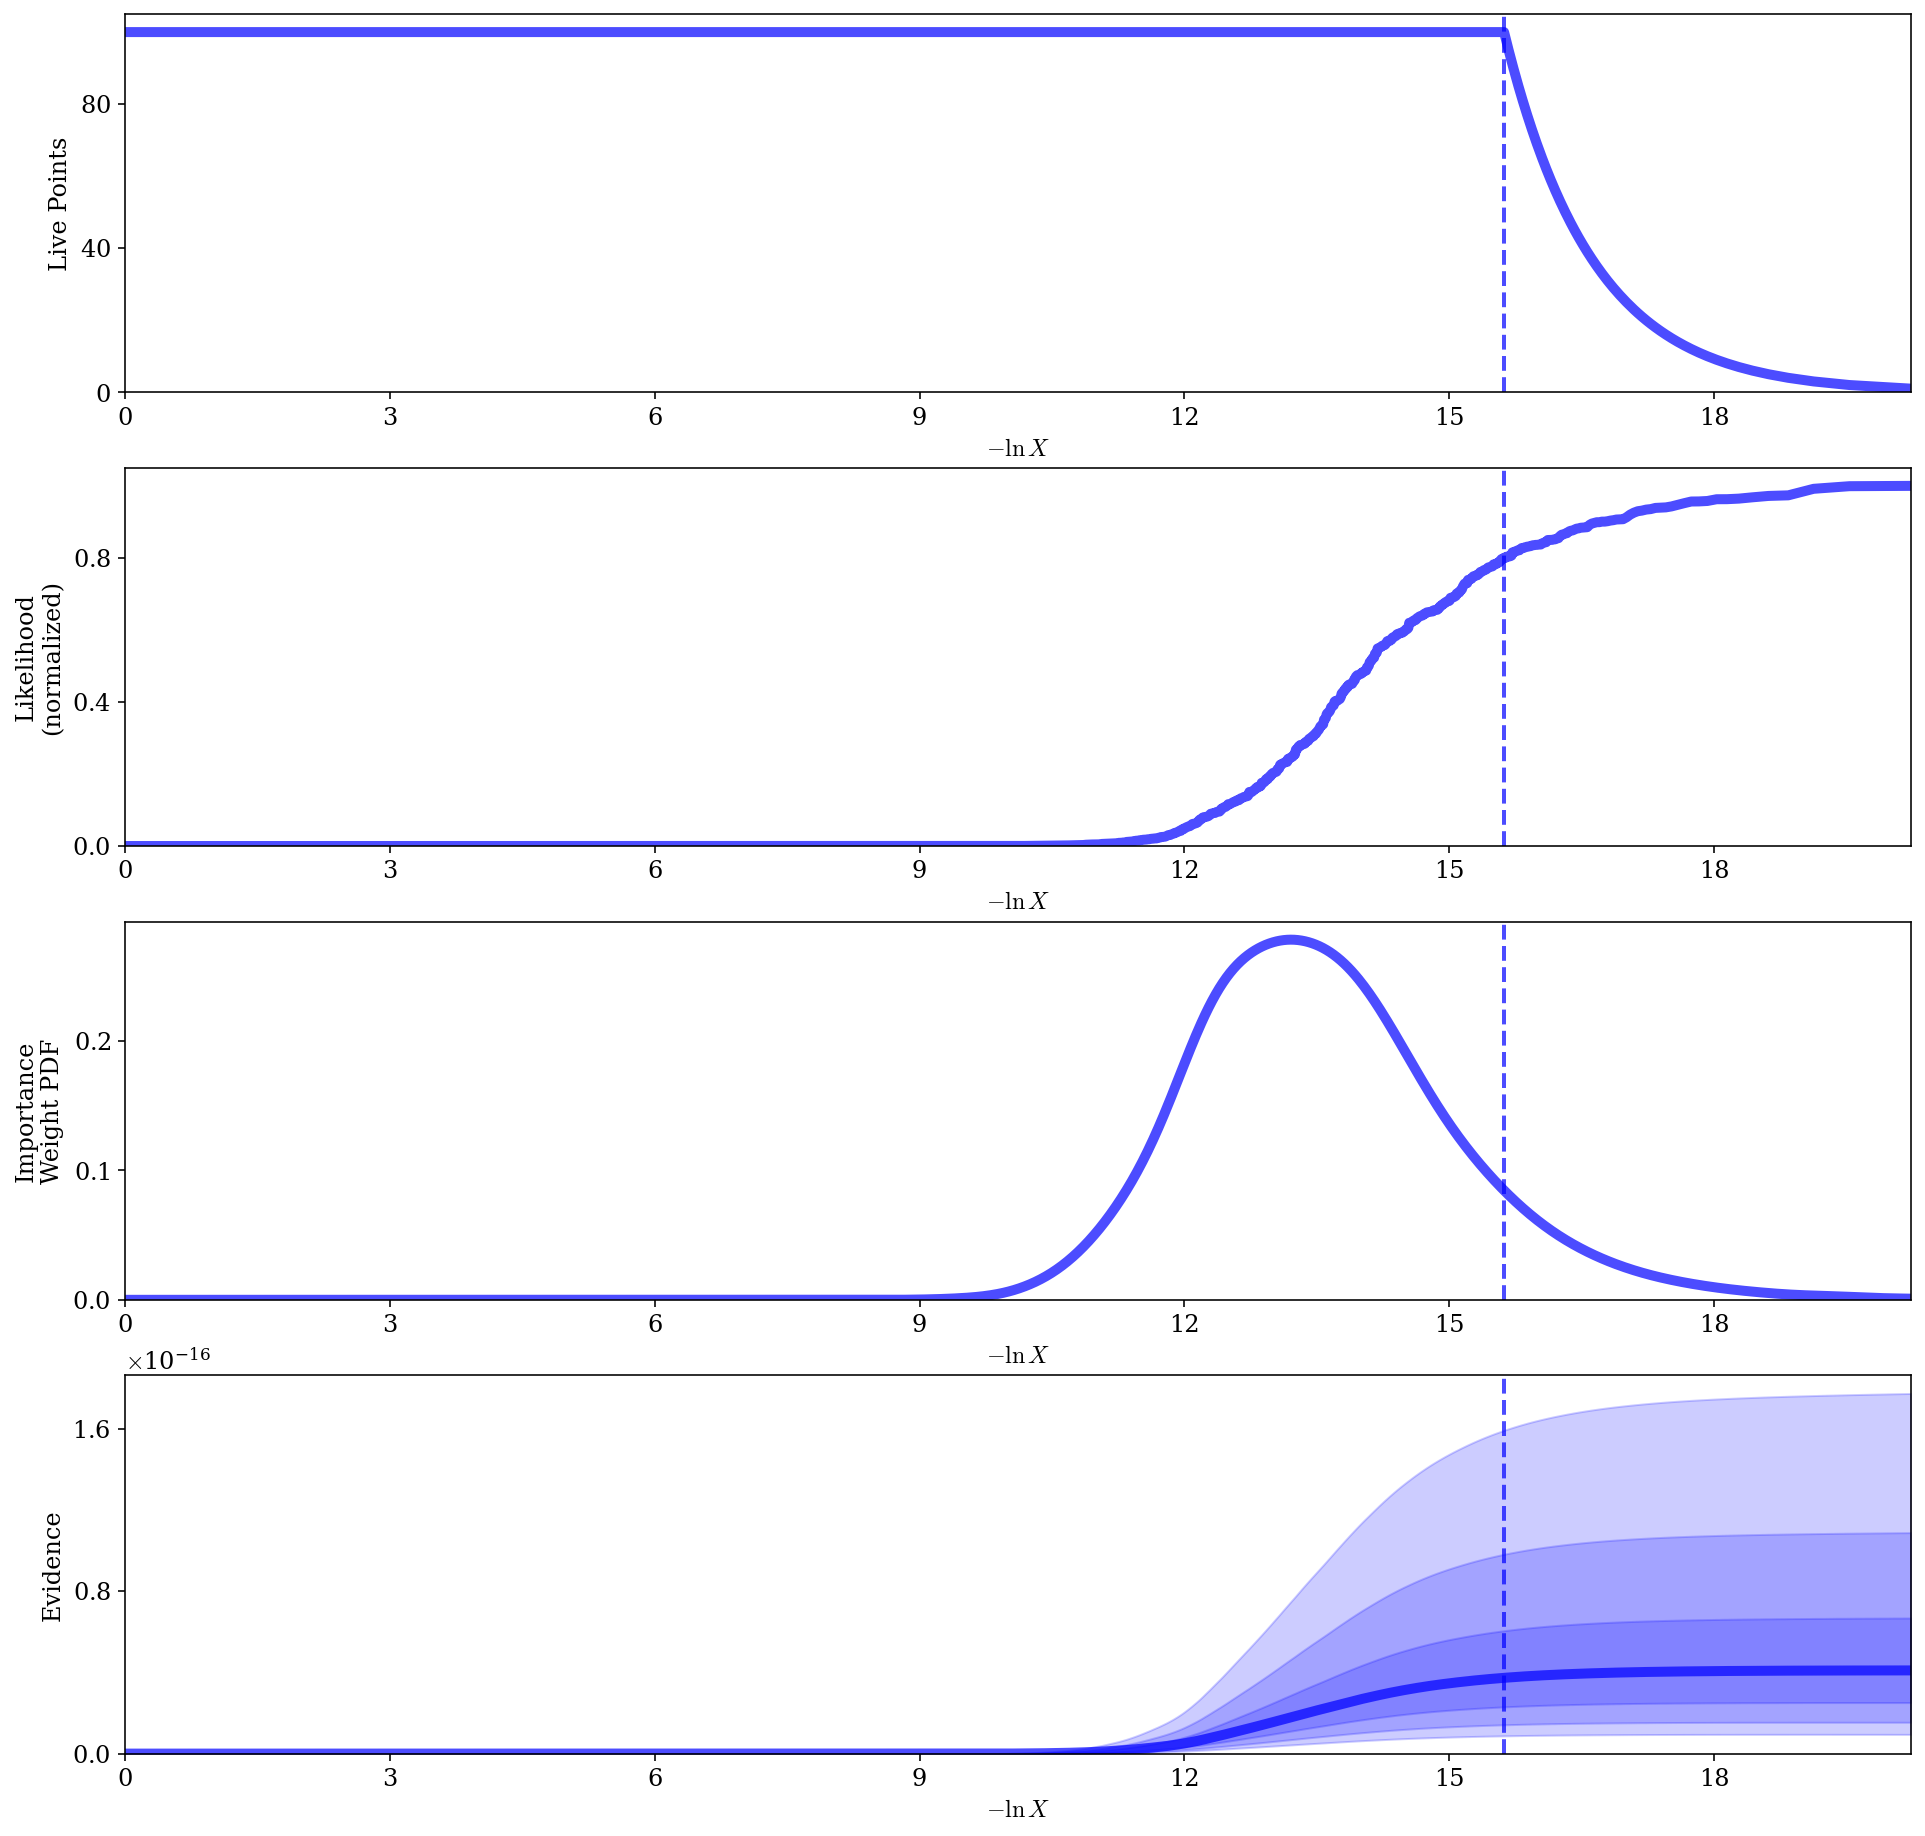

In [114]:
rfig, raxes = dyplot.runplot(results)

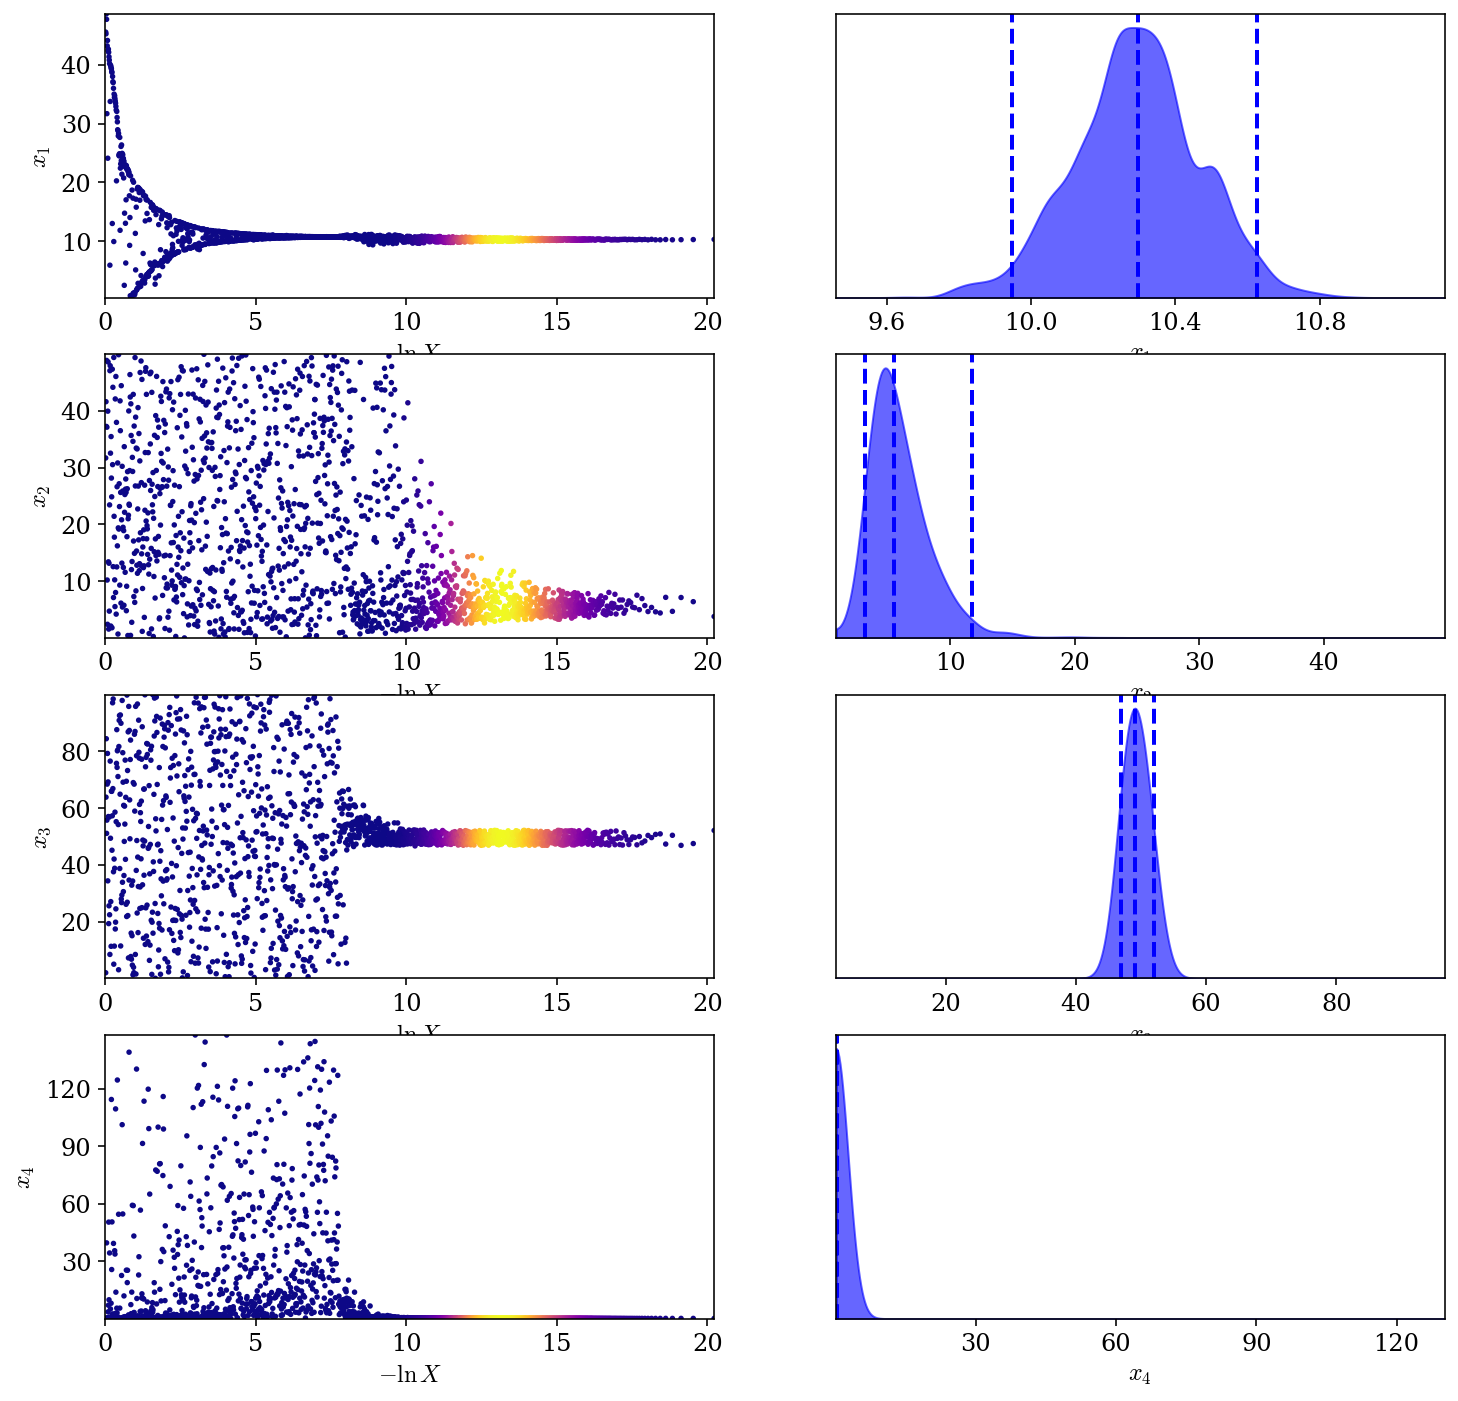

In [115]:
tfig, taxes = dyplot.traceplot(results)

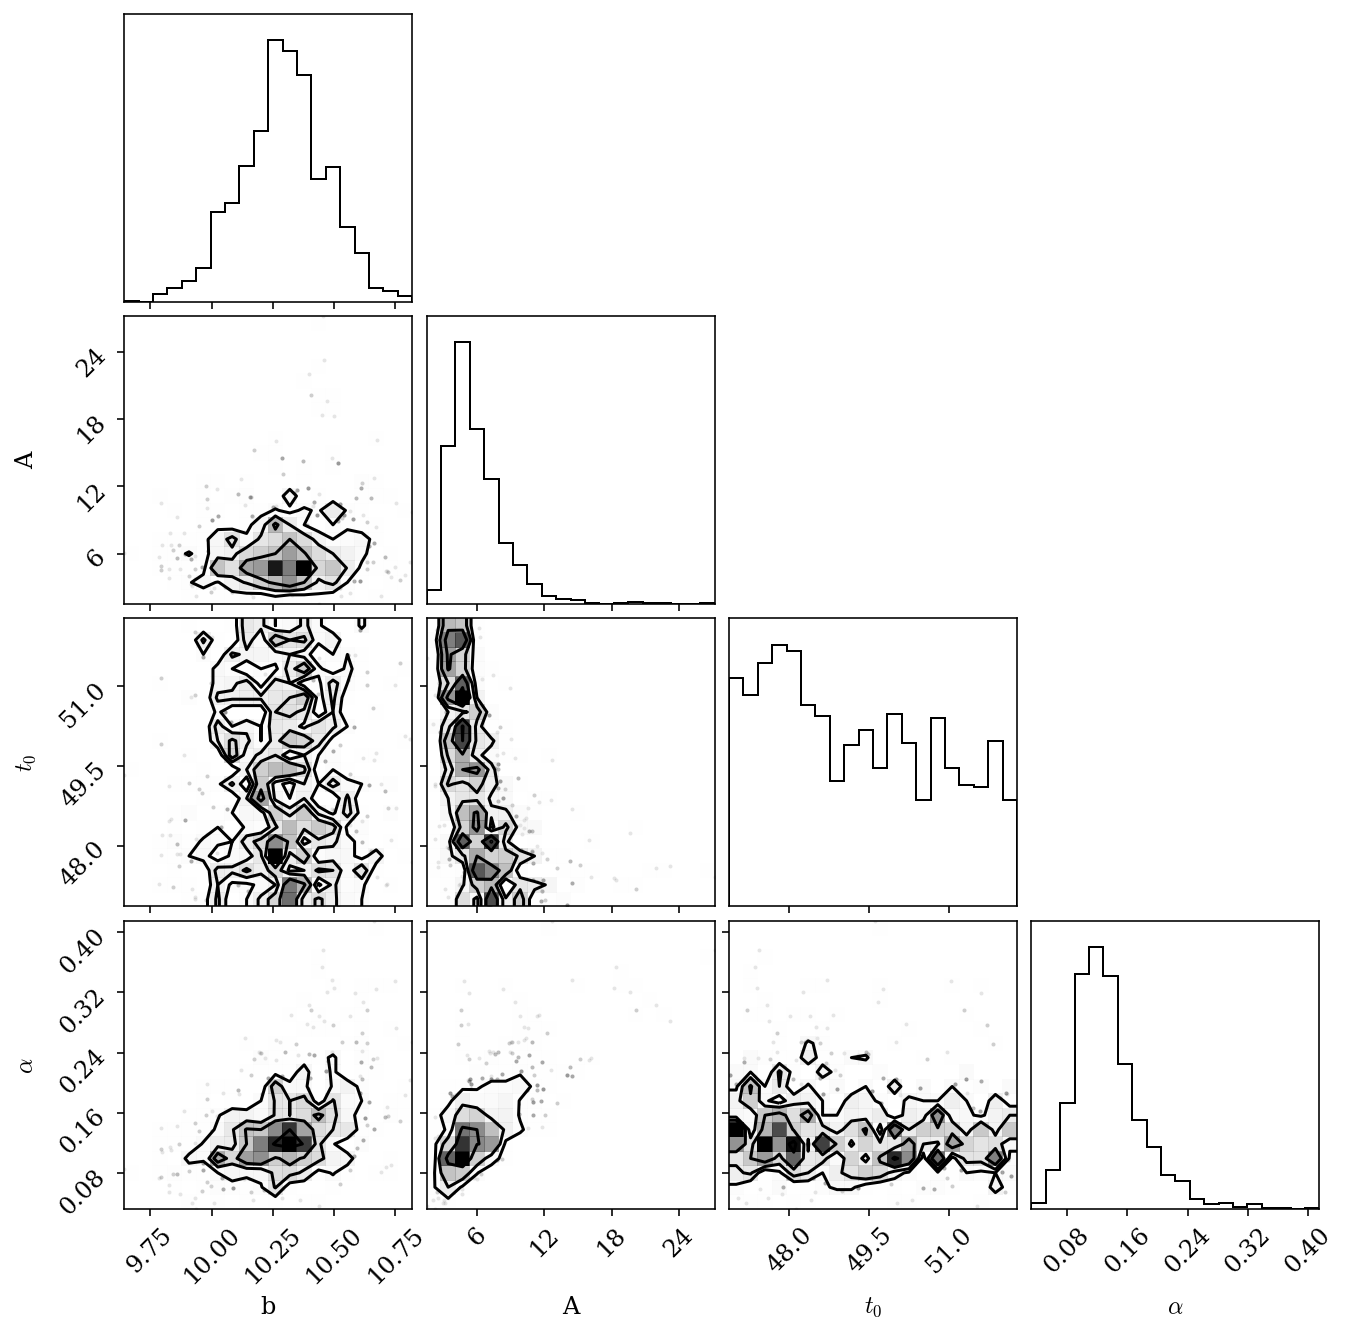

In [116]:
samples = results.samples  # samples
weights = np.exp(results.logwt - results.logz[-1])  # normalized weights

samples_equal = dyfunc.resample_equal(samples, weights)
labels = ['b', 'A', r'$t_0$', r'$\alpha$']

corner.corner(samples_equal, labels=labels);

In [117]:
#statistics
burst_evidence = results.logz[-1]
quantiles = [dyfunc.quantile(samps, [0.5, 0.05, 0.95], weights=weights)
             for samps in samples.T]
for i in range(ndim):    
    print(labels[i] + '= %.2f + %.2f - %.2f' % (quantiles[i][0], quantiles[i][0] - quantiles[i][1], quantiles[i][2] - quantiles[i][0]))

b= 10.30 + 0.29 - 0.28
A= 5.45 + 2.17 - 5.03
$t_0$= 49.09 + 2.02 - 2.79
$\alpha$= 0.13 + 0.05 - 0.09


In [118]:
results.summary()

Summary
nlive: 100
niter: 1569
ncall: 7723
eff(%): 21.611
logz: -37.734 +/-  0.488


### Gaussian profile

In [72]:
#dynesty
ndim = 4
sampler = dynesty.NestedSampler(log_likelihood, prior, ndim, logl_args=[t, flux, sigma_flux, 'gauss_model'], ptform_args=[limits, 'gauss_model'], nlive = 100)
sampler.run_nested()
results_g = sampler.results

1677it [00:44, 37.34it/s, +100 | bound: 31 | nc: 1 | ncall: 8426 | eff(%): 21.089 | loglstar:   -inf < -26.253 <    inf | logz: -40.693 +/-  0.503 | dlogz:  0.001 >  0.109]


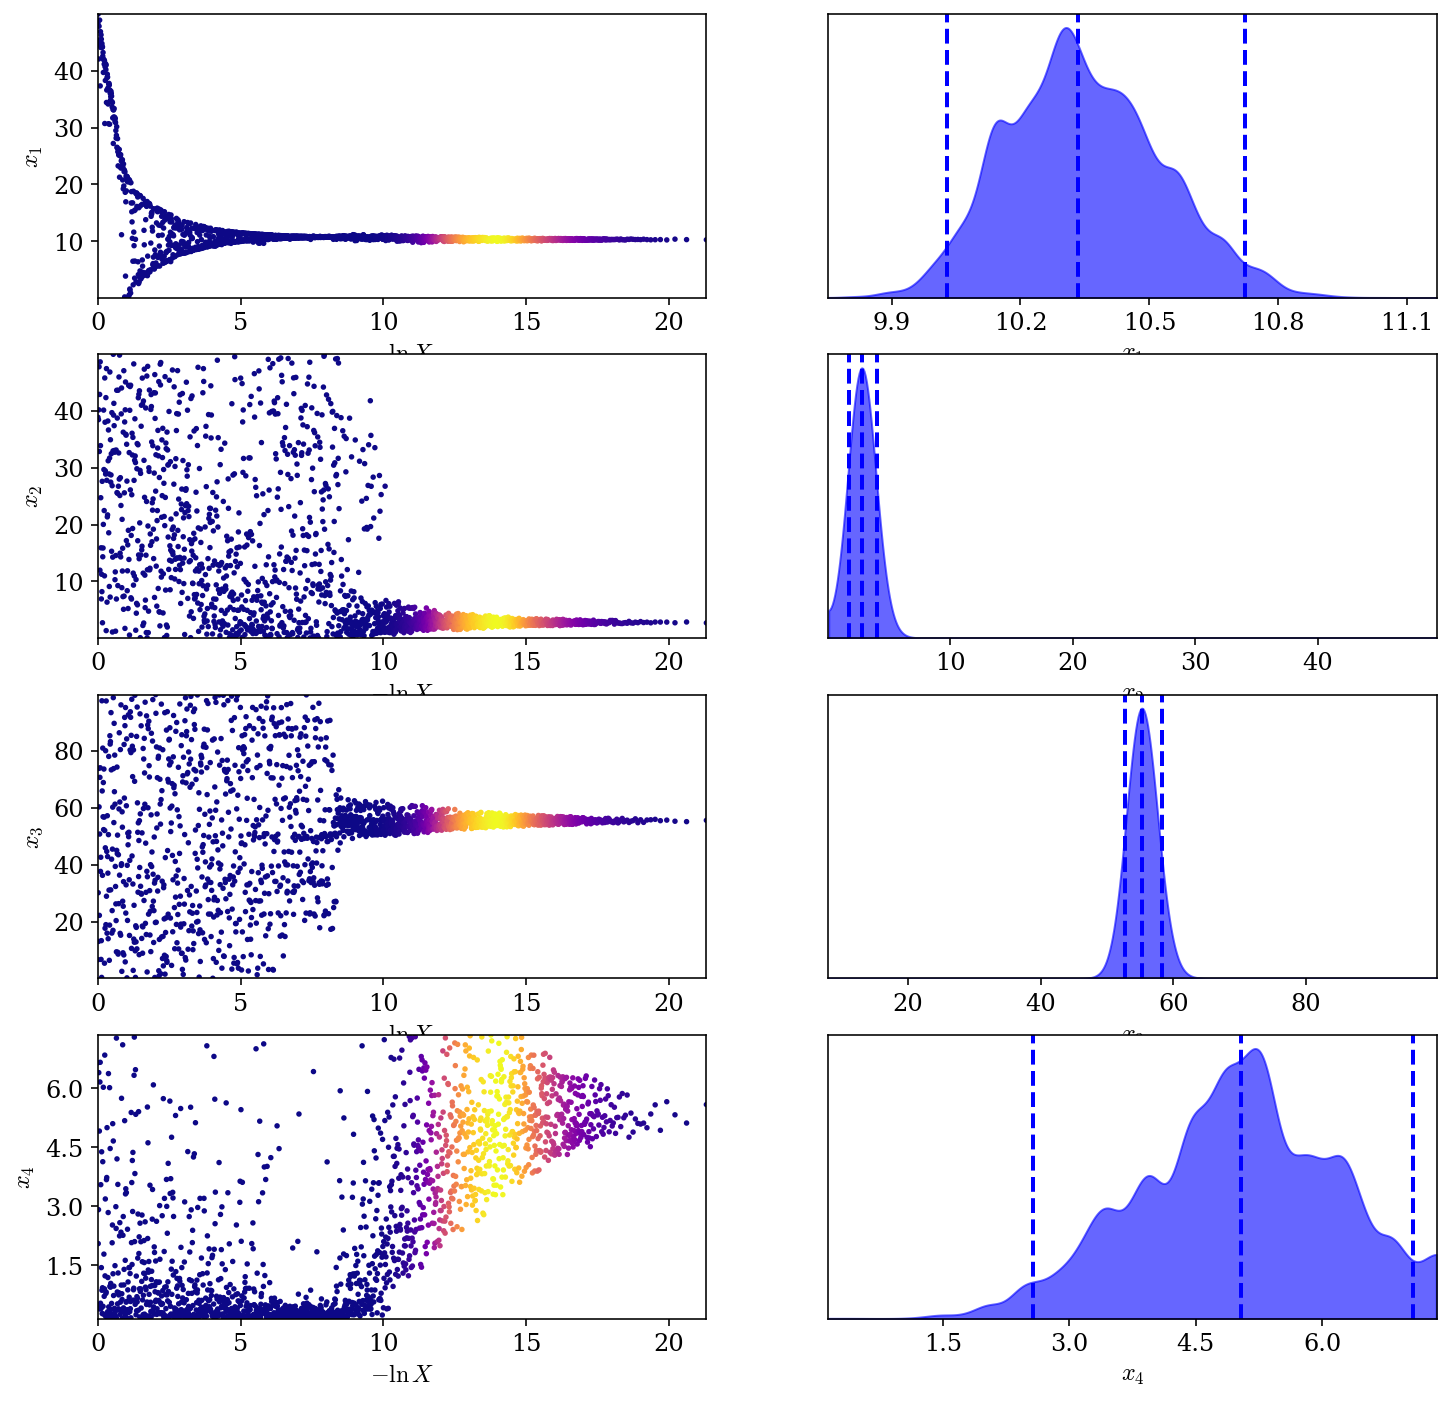

In [73]:
tfig, taxes = dyplot.traceplot(results_g)

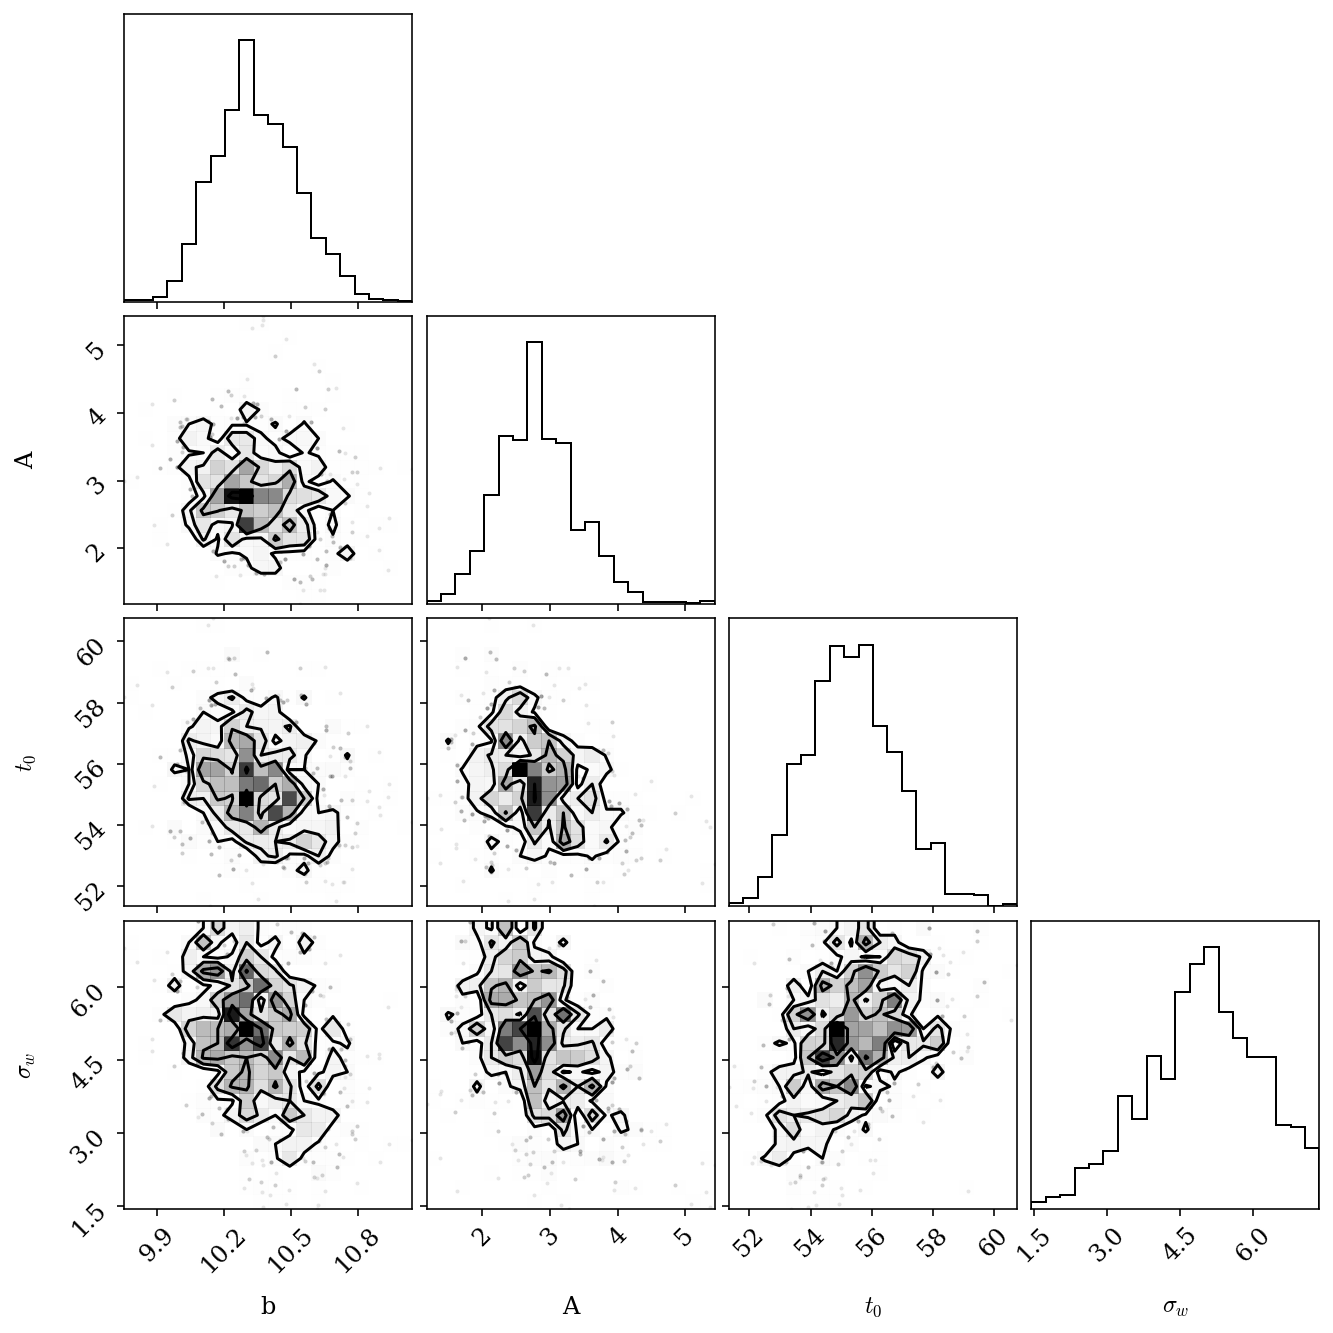

In [74]:
samples_g = results_g.samples  # samples
weights_g = np.exp(results_g.logwt - results_g.logz[-1])  # normalized weights

samples_g_equal = dyfunc.resample_equal(samples_g, weights_g)
labels_g = ['b', 'A', r'$t_0$', r'$\sigma_w$']

corner.corner(samples_g_equal, labels=labels_g);

In [75]:
#statistics
gauss_evidence = results_g.logz[-1]
quantiles = [dyfunc.quantile(samps, [0.5, 0.05, 0.95], weights=weights_g)
             for samps in samples_g.T]
for i in range(ndim):    
    print(labels_g[i] + '= %.2f + %.2f - %.2f' % (quantiles[i][0], quantiles[i][0] - quantiles[i][1], quantiles[i][2] - quantiles[i][0]))

b= 10.33 + 0.27 - 0.33
A= 2.79 + 0.86 - 1.06
$t_0$= 55.32 + 2.16 - 2.61
$\sigma_w$= 5.04 + 2.06 - 1.78


In [77]:
results_g.summary()

Summary
nlive: 100
niter: 1677
ncall: 8426
eff(%): 21.089
logz: -40.693 +/-  0.503


### Bayesian evidence

In [119]:
evidence_ratio = burst_evidence - gauss_evidence
print(evidence_ratio / np.log(10), np.exp(evidence_ratio))

1.2851571661967607 19.28222588603778


evidence in favour of the burst model

In [124]:
# 100 random samples
N_rand = 20
mask = np.random.choice(len(samples_equal), size = N_rand)
choices = samples_equal[mask]
grid = np.linspace(min(t), max(t), 100)

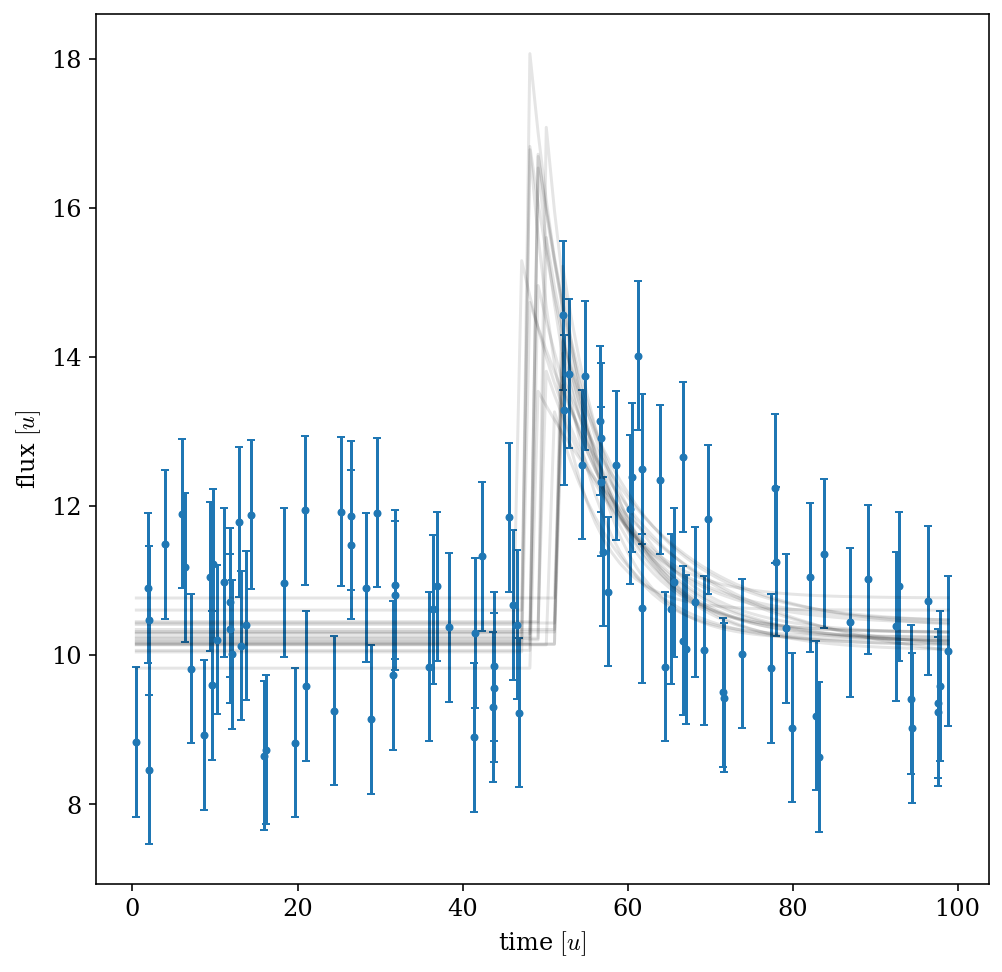

In [125]:
#plot
plt.figure()
plt.errorbar(t, flux, yerr = sigma_flux, fmt ='.', capsize = 2)

for choice in choices:
    plt.plot(grid, burst_model(choice, grid), c='k', alpha = .1)

plt.xlabel(r'time $[u]$')
plt.ylabel(r'flux $[u]$')
plt.show()